# Notebook 1 - Demo

By Vincent Blay, May 2022

This notebook was developed using **RPReactor 3.8** kernel on [jprime.lbl.gov](https://gpu2.ese.lbl.gov/).

In this notebook we demonstrate the use of MACAW embeddings to describe molecules and train regression models of different molecular properties. The results illustrate the usefulness and speed of the approach and its compatibility with small and medium-sized datasets that are commonly found in the biosciences.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn_rvm import EMRVR

from rdkit import SimDivFilters
from rdkit.Chem import rdMolDescriptors

import sys
sys.path.append('../')

import macaw
print(macaw.__version__)
from macaw import *

%run "./plotting.py"

1.0.1


In [2]:
%config InlineBackend.figure_format = 'retina'

## Research Octane Number (RON)

Let us load the data and look at the distribution:

In [3]:
df = pd.read_csv("./data/data_RON.csv")
smiles = df.Smiles
Y = df.RON
print(len(smiles))

194


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


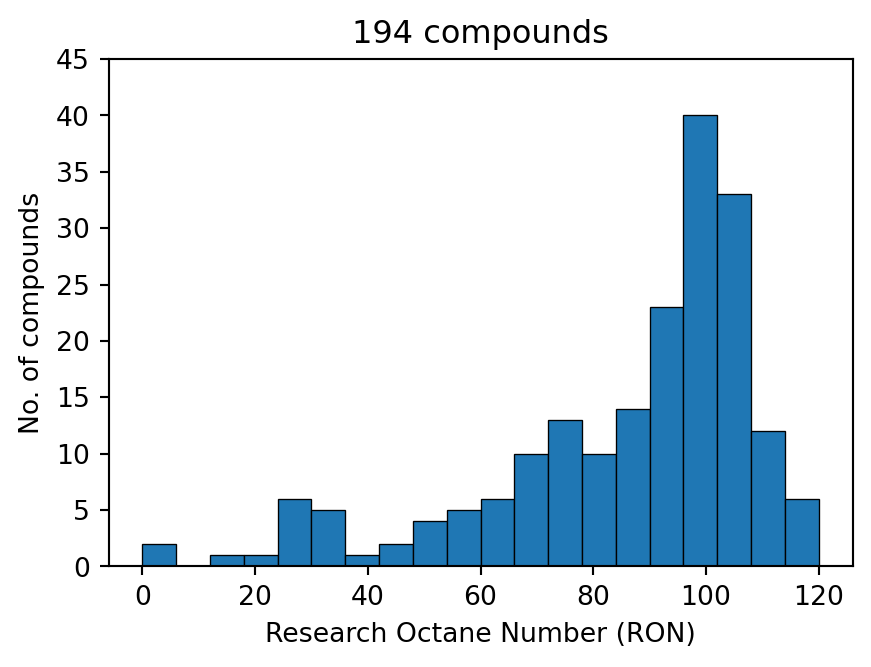

In [4]:
plot_histogram(Y, xlabel="Research Octane Number (RON)")

Let us split the data in training and validation sets:

In [5]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

Compute the MACAW embeddings of the molecules is very easy. We just initialize the embedder:

In [6]:
mcw = MACAW(random_state=42)
mcw.fit(smi_train)

And then we project the training molecules:

In [7]:
X_train = mcw.transform(smi_train)
X_train[0:4]

array([[ 0.19884805,  0.2409601 , -0.06775784, -0.02118356,  0.01205462,
         0.0092095 , -0.01561448, -0.0151575 ,  0.04589545, -0.02675224,
         0.01445283,  0.0022183 ,  0.02020615, -0.00287598,  0.0334231 ],
       [-0.03861072, -0.07373147,  0.12948979,  0.16329053,  0.11389935,
         0.12492843,  0.17406906, -0.02258431,  0.11506867,  0.00436288,
         0.00761693, -0.07656237, -0.04965525, -0.0764287 , -0.00775711],
       [ 0.1488714 ,  0.07679446,  0.02132863, -0.02997206,  0.00108838,
        -0.01158404,  0.04001913, -0.03045062, -0.03971427,  0.01451947,
         0.00394997,  0.05331182, -0.01309209,  0.00505506,  0.02383794],
       [ 0.02841089, -0.18733468, -0.1250562 , -0.10074994,  0.03711881,
        -0.08807791, -0.16081502, -0.13302582, -0.09786195,  0.05021411,
         0.01384474,  0.03374984, -0.09693374,  0.0429507 ,  0.05853095]])

The fit and transform process can be done faster in one step using the `fit_transform` method.

A variety of fingerprints (`type_fp`) and similarity metrics (`metric`) are available and can be tuned to maximize the performance of the embedding for a given problem. The dimensionality of the embedding can be set using the `n_components` argument.

As an optional parameter, the property values can also be provided when fitting the embedder (`Y=y_train`). In this case, it will choose the landmark molecules more uniformly throughout the RON range. If not provided, landmark molecules are chosen randomly.

In [8]:
mcw = MACAW(type_fp='atompairs', metric='rogot-goldberg', n_components=15, n_landmarks=100, random_state=57)
X_train = mcw.fit_transform(smiles, Y=y_train)
X_train[0:4]

array([[-0.40130185,  0.08210583,  0.19027524, -0.164668  ,  0.0217731 ,
        -0.29688321,  0.03985101, -0.14683456,  0.11241473,  0.01223104,
         0.045353  ,  0.08147502, -0.05778315,  0.01017389, -0.04357766],
       [ 0.03606253, -0.13709874,  0.15647348,  0.05091909, -0.04166269,
         0.01842223,  0.1741296 ,  0.08845769, -0.07214221, -0.17079708,
         0.04743385,  0.0664307 ,  0.03586416,  0.00852211,  0.13308152],
       [ 0.04549525, -0.28584305, -0.08308062, -0.18802785,  0.30988297,
         0.18900348,  0.00656332, -0.02394803,  0.10900851, -0.13882069,
        -0.0670823 ,  0.16844191, -0.01884168,  0.2783186 , -0.18573517],
       [ 0.14818929, -0.18528988,  0.10278648, -0.25072034,  0.29944551,
         0.2546804 , -0.13569402, -0.11437833,  0.08961876, -0.00056613,
         0.16144403,  0.20385203, -0.11389405, -0.04488207, -0.06987032]])

In order to automate the selection of the `type_fp` and `metric`, we have implemented the function `MACAW_optimus`, which can help select a good combination. Internally, it explores a variety of embeddings by combining these hyperparameters and use them to train SVM models, which are assessed using cross_validation. The embedding leading to the best performing model is returned to the user.

In [9]:
mcw = MACAW_optimus(smi_train, y_train, verbose=True, n_components=15, n_landmarks=100, random_state=57)

Problem type identified as regression
morgan2 & tanimoto: 0.511
morgan3 & tanimoto: 0.497
rdk5 & tanimoto: 0.584
rdk7 & tanimoto: 0.599
featmorgan2 & tanimoto: 0.553
featmorgan3 & tanimoto: 0.548
maccs & tanimoto: 0.633
avalon & tanimoto: 0.477
atompairs & tanimoto: 0.654
torsion & tanimoto: 0.543
pattern & tanimoto: 0.469
secfp6 & tanimoto: 0.498
layered & tanimoto: 0.633
atompairs & tanimoto: 0.654
atompairs & cosine: 0.668
atompairs & dice: 0.656
atompairs & sokal: 0.649
atompairs & kulczynski: 0.674
atompairs & mcconnaughey: 0.674
atompairs & braun-blanquet: 0.645
atompairs & rogot-goldberg: 0.658
atompairs & asymmetric: 0.658
atompairs & manhattan: 0.652
atompairs & blay-roger: 0.660
Setting recommended combination: atompairs & kulczynski


The embeddings for any new molecules can be commputed easily: we just provide the SMILES to the `transform()` method of the embedder. 

Let us compute the embeddings of the test set molecules.

In [10]:
X_train = mcw.transform(smi_train)
X_test = mcw.transform(smi_test)

In [11]:
X_test.shape

(39, 15)

Now we can use the embeddings as predictors for any machine learning tool, from linear models to neural networks. In this notebook, we will mainly use Support Vector Machines (SVM) from the scikit-learn library.

As an example, here we explore a Support Vector Regressor (SVR) from the `sklearn` package.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


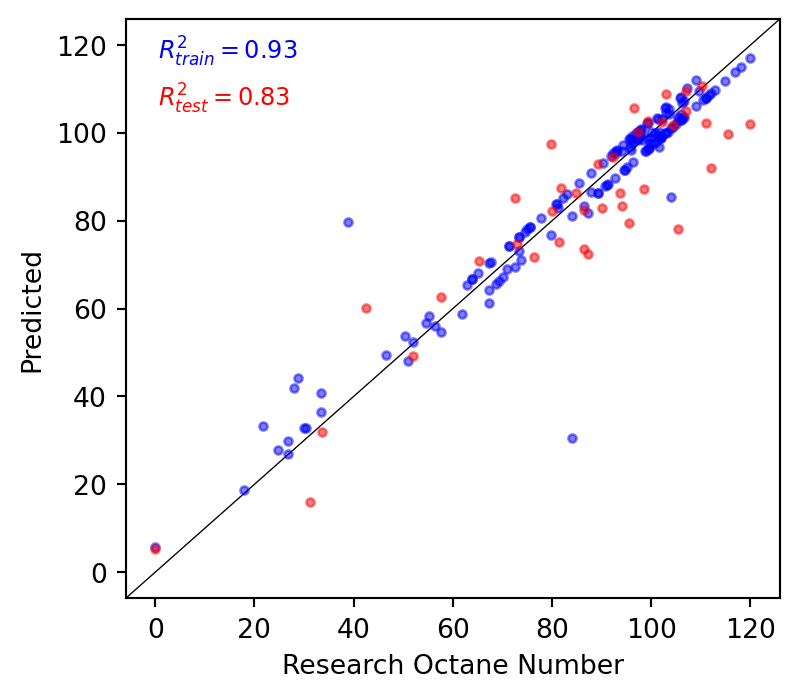

In [12]:
regr = SVR(kernel='rbf', C=100, epsilon=3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Research Octane Number", savetitle="./results/macaw/RON.svg") 

As another example, we also train a relevance vector regressor (RVR) using the same MACAW features. This type of model can deal automatically with the regularization (`gamma='scale'`) and provide uncertainty estimates of the predictions. Information about this package can be found [here](https://sklearn-rvm.readthedocs.io/en/latest/index.html).

In [13]:
regr = EMRVR(kernel='rbf', gamma=8)
regr.fit(X_train, y_train)

# Train set predictions
y_train_pred, y_train_std = regr.predict(X_train, return_std=True)

# Test set predictions
y_test_pred, y_test_std = regr.predict(X_test, return_std=True)

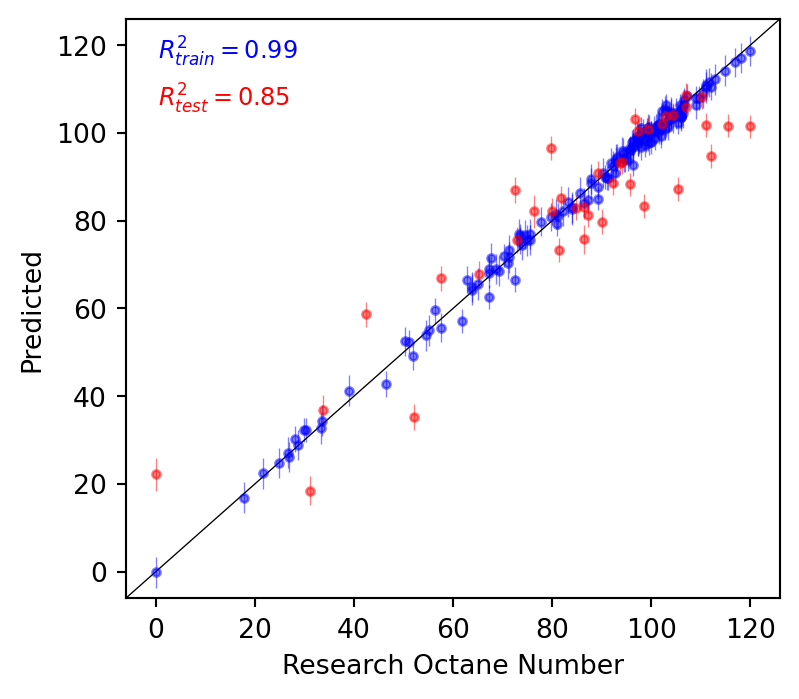

In [14]:
# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            y_train_std=y_train_std, y_test_std=y_test_std, xlabel="Research Octane Number") 

## Yield Sooting Index

Here we demonstrate how MACAW embeddings can help model Yield Soot Index (YSI), another complex molecular property.

In [15]:
df = pd.read_csv('./data/data_YSI.csv')
smiles = df.Smiles
Y = df.YSI
print(len(smiles))

610


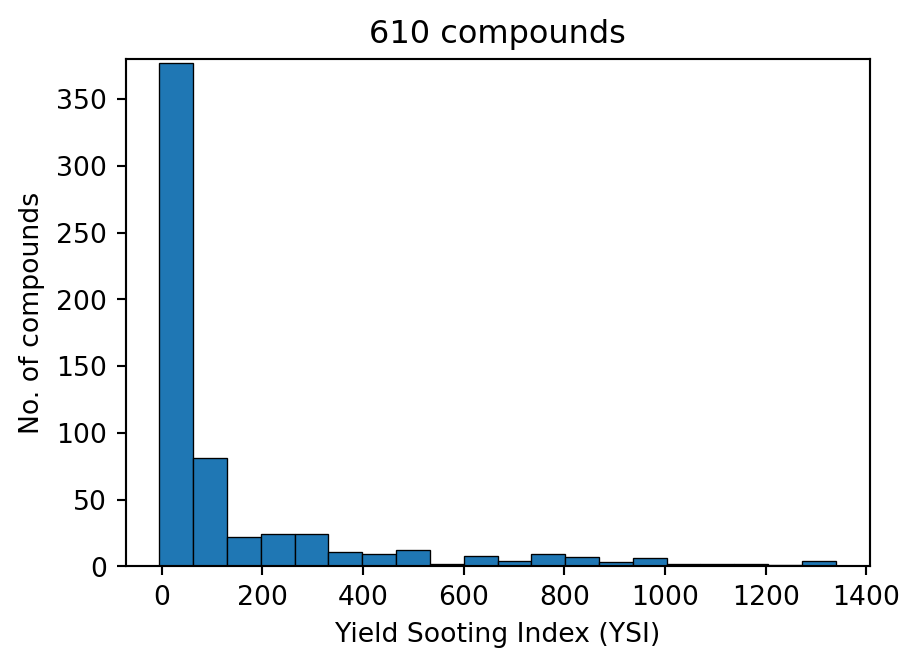

In [16]:
plot_histogram(Y, xlabel="Yield Sooting Index (YSI)")

In this case, we see that the data distribution is very skewed. There are different approaches to deal with this, for example, we could transform the YSI values to  get a more uniform distribution. For illustration purposes, we will work with the data as is.

We apply a stratified sampling to hold out the validation set in this case:

In [17]:
bins = np.linspace(min(Y), max(Y), 10+1)
Y_binned = np.digitize(Y, bins[:-1])
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42, stratify=Y_binned)

Next we compute the MACAW embeddings using only training data. In a case like this, it can be useful to provide property information (`Y=y_train`) to achieve a more balanced choice of landmarks. 

In [18]:
mcw = MACAW_optimus(smi_train, y_train, random_state=29)

X_train = mcw.transform(smi_train)

Problem type identified as regression
Setting recommended combination: atompairs & blay-roger


Since we did not transform the YSI data, we may want to introduce sample weights in the model. The way we do it here is by binning molecules as a function of YSI values, and then 
setting the weight of each datum in inverse proportion to the number of molecules in the bucket.

In [19]:
nbins = 10
leny = len(y_train)
bins = np.linspace(min(y_train), max(y_train), nbins+1)
y_binned = np.digitize(y_train, bins[:-1])
weights = [1./nbins]*leny
for i in range(leny):
    weights[i] = weights[i]/sum(y_binned==y_binned[i])
weights = np.asarray(weights)
weights = weights/weights.mean()

Now we can train the model. As in the other regression examples, we use a SVR. For this model, the weights provided will scale the regularization in different regions of space, in relation to the global regularization set by `C`.

In [20]:
for C in [30,100,300,500]:
    regr = SVR(kernel='rbf', C=C, epsilon=20)
 
    scores = cross_val_score(regr, X_train, y_train, cv=5, fit_params={'sample_weight': weights})
    print(scores.mean())

0.689854988109374
0.7750986244555093
0.8136474547334709
0.8247410243773544


And we train the final model:

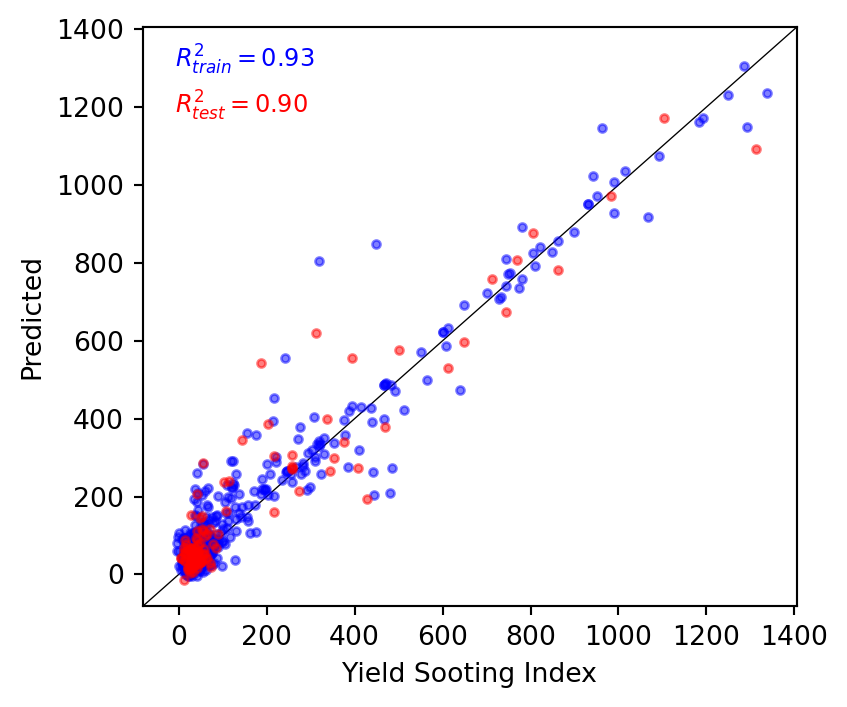

In [21]:
regr = SVR(kernel = 'rbf', C=500, epsilon=20)
regr.fit(X_train,y_train, sample_weight=weights)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, xlabel="Yield Sooting Index", savetitle="./results/macaw/YSI.svg") 

For comparison, we can train a model without using the binned landmark selection strategy:

In [22]:
mcw = MACAW(type_fp='atompairs', metric='blay-roger', random_state=29)

X_train = mcw.fit_transform(smi_train)

In [23]:
nbins = 10
leny = len(y_train)
bins = np.linspace(min(y_train), max(y_train), nbins+1)
y_binned = np.digitize(y_train, bins[:-1])
weights = [1./nbins]*leny
for i in range(leny):
    weights[i] = weights[i]/sum(y_binned==y_binned[i])
weights = np.asarray(weights)
weights = weights/weights.mean()

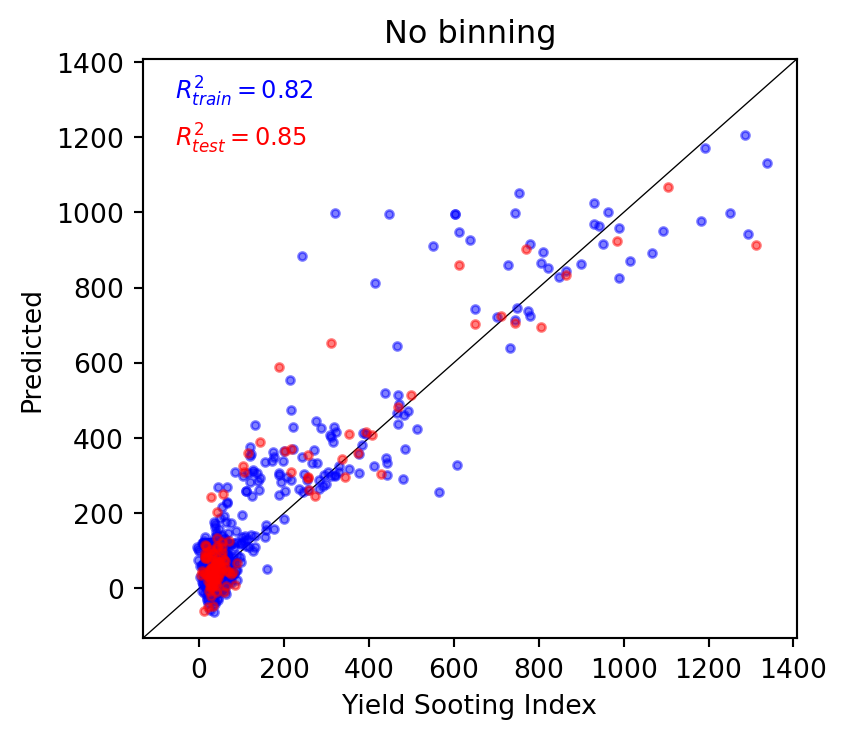

In [24]:
regr = SVR(kernel = 'rbf', C=500, epsilon=20)
regr.fit(X_train,y_train, sample_weight=weights)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, xlabel="Yield Sooting Index", title="No binning") 

We can also disable the use of different sample weights:

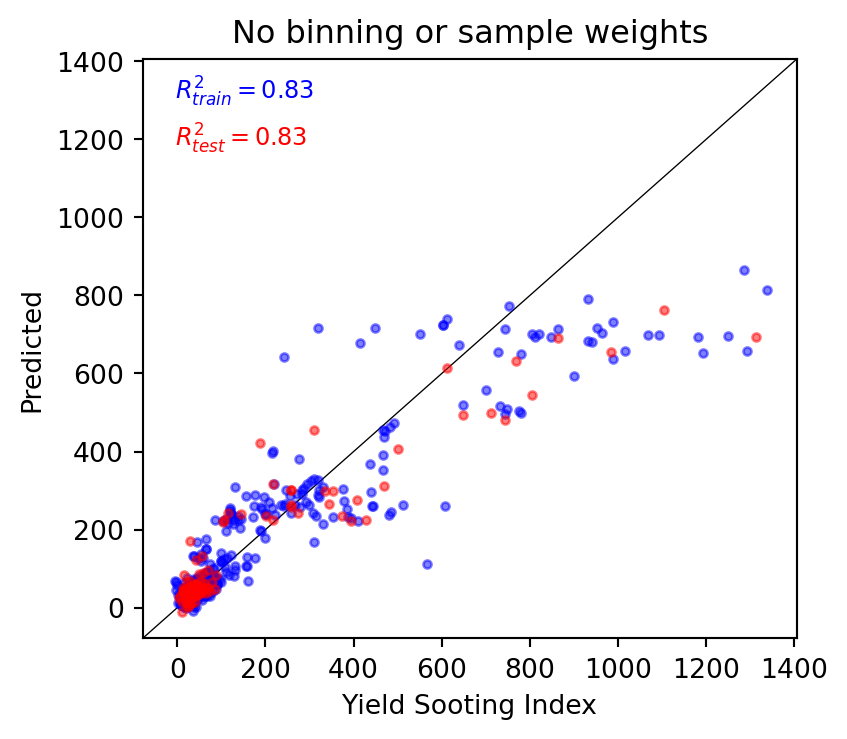

In [25]:
regr = SVR(kernel = 'rbf', C=500, epsilon=20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, xlabel="Yield Sooting Index", title="No binning or sample weights") 

We see that using the binned landmark selection strategy and weighting the datapoints leads to better performance in this problem.

##  Melting Point (MP)

In [26]:
df = pd.read_csv("./data/data_MP.csv")
smiles = df.Smiles
Y = df.mpC
print(len(smiles))

27976


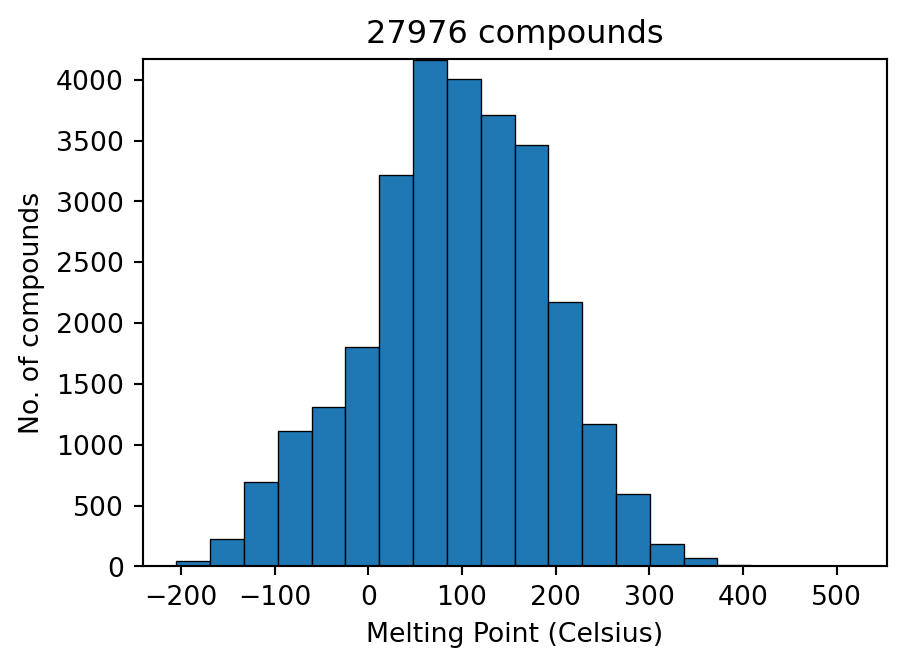

In [27]:
plot_histogram(Y, xlabel="Melting Point (Celsius)")

In [28]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)
print(len(smi_train))

22380


In [29]:
mcw = MACAW(type_fp='maccs', metric='tanimoto', n_landmarks=100, random_state=51)
mcw.fit(smi_train, Y=y_train)

In [30]:
X_train = mcw.transform(smi_train)

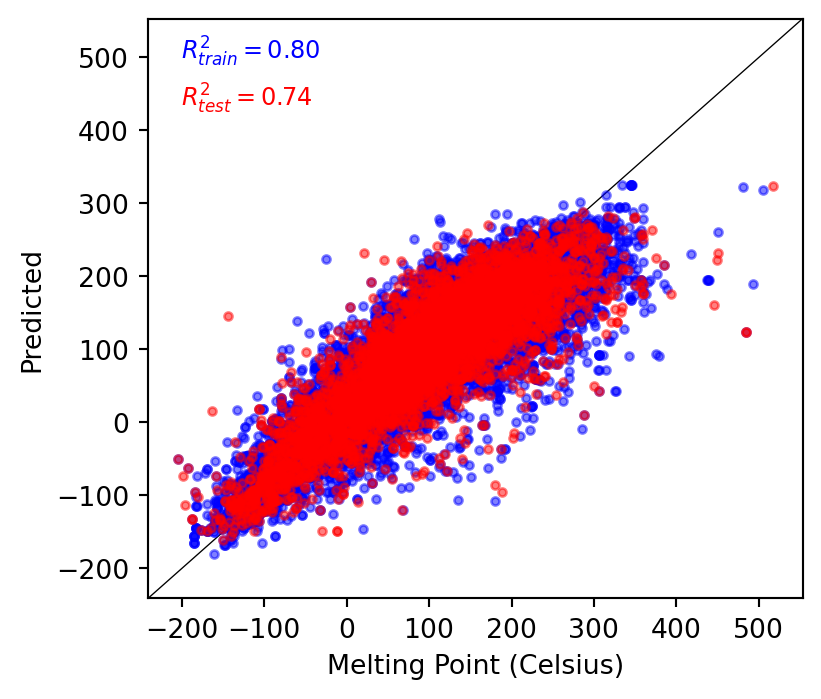

In [31]:
regr = SVR(kernel = 'rbf', C=500, epsilon=20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Melting Point (Celsius)", savetitle="./results/macaw/MP.svg") 

We can also manually define what molecules to use as landmarks. As an example, we will select 100 diverse molecules as landmarks using rdkit's `MaxMinPicker`:

In [32]:
mols_train = [Chem.MolFromSmiles(smi) for smi in smi_train]
fps_train = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m,2, 2048) for m in mols_train]
mmp =SimDivFilters.MaxMinPicker()
idx_landmarks = np.array(mmp.LazyBitVectorPick(fps_train,len(fps_train),100,seed=42))
idx_landmarks

array([ 8382,    10,    26,   483,   533,  1001,  1803,  1864,  2465,
        4155,  4749,  5727,  6878,  7093, 15469, 17840, 17877, 19471,
       20703, 13759, 10551,  1877,   756, 22306,  4014,  3790, 10982,
       20664, 11514,  8272, 19809,    72, 19490,  8729,  6446, 20101,
       21425,  3414,  5292,  5577, 14529, 17763, 10546, 10301,  2588,
        5101, 19226, 15497, 14498,  6937,   551,  2348,  2537,  8862,
       16955, 22267,   950,  1074,  9834, 10498, 18953, 16115,  9338,
        1235, 15715,  3869,  1296,  1841,  2375,  4501,  5256,  5291,
        6572, 15818,  2621,  5128,  6927, 10054, 14254, 19759,  4733,
        4759,  3080,  5924,   772, 21982,   967,  1372,  2658,  9763,
       13094, 15838, 20337,  1418,  4963,  8172, 18399, 19404,  6706,
       15548])

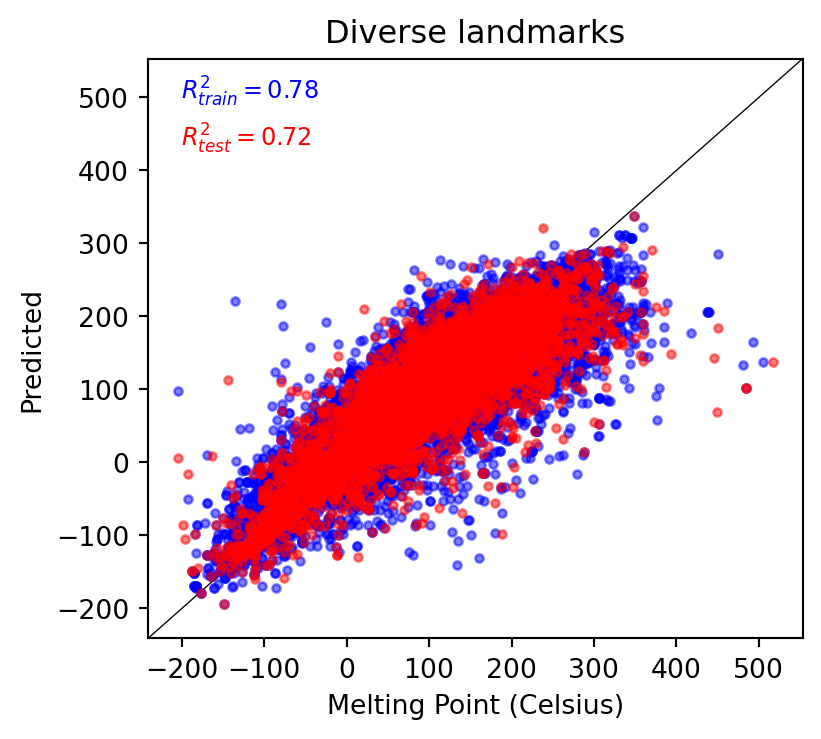

In [33]:
mcw_diverse = MACAW(type_fp="maccs", metric="tanimoto", idx_landmarks=idx_landmarks)
X_train = mcw_diverse.fit_transform(smi_train)

regr = SVR(kernel='rbf', C=500, epsilon=10)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw_diverse.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            title="Diverse landmarks", xlabel="Melting Point (Celsius)") 

MACAW also allows concatenating fingerprints, which may improve performance in some cases:

In [34]:
mcw = MACAW(n_components=20, n_landmarks=200, type_fp='maccs+atompairs', metric='tanimoto', random_state=51)
mcw.fit(smi_train, Y=y_train)

In [35]:
X_train = mcw.transform(smi_train)

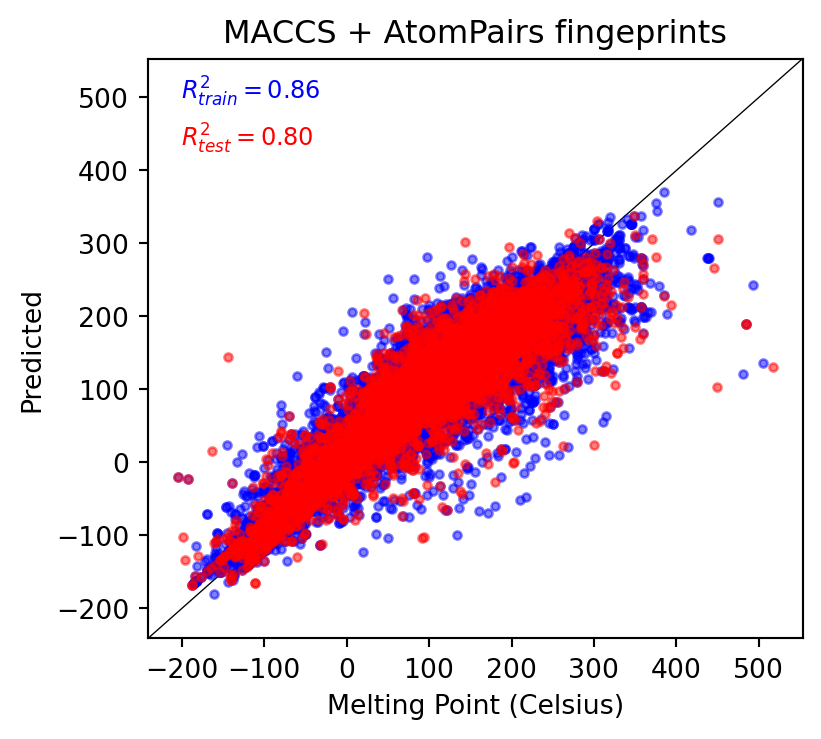

In [36]:
regr = SVR(kernel='rbf', C=500, epsilon=20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Melting Point (Celsius)", title="MACCS + AtomPairs fingeprints", savetitle="./results/macaw/MP_2.svg") 